# Classification

In this lab, we will be building and evaluating different classifiers for recognising handwritten digits of MNIST dataset. We will be doing the following:

1. Binary Classification of MNIST Dataset

In the first set of tasks, you will evaluate a number of popular classifiers for the task of recognizing handwritten digits from MNIST dataset. Specifically, we will focus on distinguishing between 7 and 9 which are known to be a hard pair. 

2. Exploration of Different Evaluation Metrics. 

In the second set of tasks, you will learn how (and when) to use evaluation metrics for classifiers.

3. Parameter Tuning through Grid Search/Cross Validation and Parallelization.

You will learn how to tune your classifier and find optimal parameters using grid search. This is a very computationally intensive task - so you will also explore how to leverage parallelization capabilities of IPython kernel to get results sooner.

In [1]:
%matplotlib inline 

#Array processing
import numpy as np

#Data analysis, wrangling and common exploratory operations
import pandas as pd
from pandas import Series, DataFrame

#For visualization. Matplotlib for basic viz and seaborn for more stylish figures + statistical figures not in MPL.
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import Image

from sklearn.datasets import fetch_mldata                                                                       
from sklearn.utils import shuffle                                                                                   
from sklearn import metrics                                                                                                  
from sklearn import tree                                                                                                     
from sklearn.tree import DecisionTreeClassifier                                                       
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression                                            
from sklearn.ensemble import RandomForestClassifier                                                                                                          
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV                                                
from sklearn.preprocessing import StandardScaler

import pydot, io
import time

#######################End imports###################################


## Part 1: Binary Classification of MNIST Dataset

In the first set of tasks, you will evaluate a number of popular classifiers for the task of recognizing handwritten digits from MNIST dataset. Specifically, we will focus on distinguishing between 7 and 9 which are known to be a hard pair.

In [2]:
# Removes depreciation warnings from using fetch_mldata which will be removed in the new version
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Images = 70000 and #Pixel per image = 784
First image shows 0
The corresponding matrix version of image is 
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0  

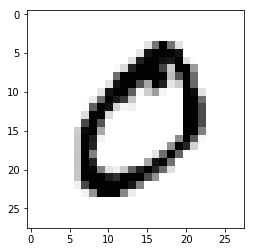

In [3]:
#Load MNIST data. fetch_mldata will download the dataset and put it in a folder called mldata. 
#Some things to be aware of:
#   The folder mldata will be created in the folder in which you started the notebook
#   So to make your life easy, always start IPython notebook from same folder.
#   Else the following code will keep downloading MNIST data
try:
    mnist = fetch_mldata("MNIST original")                                                                                   
 
except Exception as ex: 
    import tensorflow.examples.tutorials.mnist.input_data as input_data
    m=input_data.read_data_sets("MNIST")
    data = np.concatenate((m.train.images, m.test.images))
    target = np.concatenate((m.train.labels, m.test.labels))
    class dataFrame:
        def __init__(self, data, target):
            self.data = data
            self.target = target
    mnist = dataFrame(data, target)

#The data is organized as follows:
#  Each row corresponds to an image
#  Each image has 28*28 pixels which is then linearized to a vector of size 784 (ie. 28*28)
# mnist.data gives the image information while mnist.target gives the number in the image
print("#Images = %d and #Pixel per image = %s" % (mnist.data.shape[0], mnist.data.shape[1]))

#Print first row of the dataset 
img = mnist.data[0]                                                                                                          
print("First image shows %d" % (mnist.target[0]))
print("The corresponding matrix version of image is \n" , img)
print("The image in grey shape is ")
plt.imshow(img.reshape(28, 28), cmap="Greys")                                                                                
 

In [17]:
#First 60K images are for training and last 10K are for testing
all_train_data = mnist.data[:60000]                                                                                          
all_test_data = mnist.data[60000:]                                                                                           
all_train_labels = mnist.target[:60000]                                                                                      
all_test_labels = mnist.target[60000:]                                                                                       
                                                                                                                                                                                         
#For the first task, we will be doing binary classification and focus on two pairs of 
#  numbers: 7 and 9 which are known to be hard to distinguish
#Get all the seven images
sevens_data = mnist.data[mnist.target==7]      
#Get all the none images
nines_data = mnist.data[mnist.target==9]       
#Merge them to create a new dataset
binary_class_data = np.vstack([sevens_data, nines_data])    
binary_class_labels = np.hstack([np.repeat(7, sevens_data.shape[0]), np.repeat(9, nines_data.shape[0])])    

#In order to make the experiments repeatable, we will seed the random number generator to a known value
# That way the results of the experiments will always be same
np.random.seed(1234)                        
#randomly shuffle the data
binary_class_data, binary_class_labels = shuffle(binary_class_data, binary_class_labels)  
print("Shape of data and labels are :" , binary_class_data.shape, binary_class_labels.shape)  

#There are approximately 14K images of 7 and 9. 
#Let us take the first 5000 as training and remaining as test data                                          
orig_binary_class_training_data = binary_class_data[:5000]                                                  
binary_class_training_labels = binary_class_labels[:5000]                                                   
orig_binary_class_testing_data = binary_class_data[5000:]                                                   
binary_class_testing_labels = binary_class_labels[5000:] 

#The images are in grey scale where each number is between 0 to 255
# Now let us normalize them so that the values are between 0 and 1. 
# This will be the only modification we will make to the image
binary_class_training_data = orig_binary_class_training_data / 255.0                                        
binary_class_testing_data = orig_binary_class_testing_data / 255.0                                          
scaled_training_data = all_train_data / 255.0                                                                                
scaled_testing_data = all_test_data / 255.0  

Shape of data and labels are : (14251, 784) (14251,)


In [18]:
# finding the number of sevens in data
len(binary_class_training_labels[binary_class_training_labels==7])

2547

In [19]:
# Shows the values in row 0 for all 784 columns
print(binary_class_training_data[0,:])                                                                 
     
###########Make sure that you remember the variable names and their meaning
#binary_class_training_data, binary_class_training_labels: Normalized images of 7 and 9 and the correct labels for training
#binary_class_testing_data, binary_class_testing_labels : Normalized images of 7 and 9 and correct labels for testing
#orig_binary_class_training_data, orig_binary_class_testing_data: Unnormalized images of 7 and 9
#all_train_data, all_test_data: un normalized images of all digits 
#all_train_labels, all_test_labels: labels for all digits
#scaled_training_data, scaled_testing_data: Normalized version of all_train_data, all_test_data for all digits

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## Binary Classification in scikit-learn

All classifiers in scikit-learn follow a common pattern that makes life much easier. 
Follow these steps for all the tasks below.

1. Instantiate the classifier with appropriate parameters
2. Train/fit the classifier with training data and correct labels
3. Test the classifier with unseen data
4. Evaluate the performance of classifier

### Exercise 1: Decision Trees (10 marks)

In the first task, you will use Decision trees (see url
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
) for classification. 

Implement a CART decision tree with splitting criterion as entropy. Also print the learned decision tree using the supplied function "plot_tree" below.

In [20]:
def plot_dtree(model,fileName):                                                                                              
    #You would have to install a Python package pydot                                                                        
    #You would also have to install graphviz for your system - see http://www.graphviz.org/Download..php                     
    #If you get any pydot error, see url
    # http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will
    dot_tree_data = io.StringIO()                                                                                      
    tree.export_graphviz(model, out_file = dot_tree_data)                                                                   
    (dtree_graph,) = pydot.graph_from_dot_data(dot_tree_data.getvalue())                                                        
    dtree_graph.write_png(fileName)                   

In [21]:
# Exercise 1 (10 marks)
# Create a CART decision tree with splitting criterion as entropy
# Remember to set the random state to 1234

dtclf = DecisionTreeClassifier(criterion = "entropy", random_state=1234)
dtmodel = dtclf.fit(binary_class_training_data, binary_class_training_labels)
dtpred = dtclf.predict(binary_class_testing_data)
print("Decision Tree Classification Accuracy: {0:.2f}%"
      .format(metrics.accuracy_score(dtpred, binary_class_testing_labels) * 100 ))

Decision Tree Classification Accuracy: 96.94%


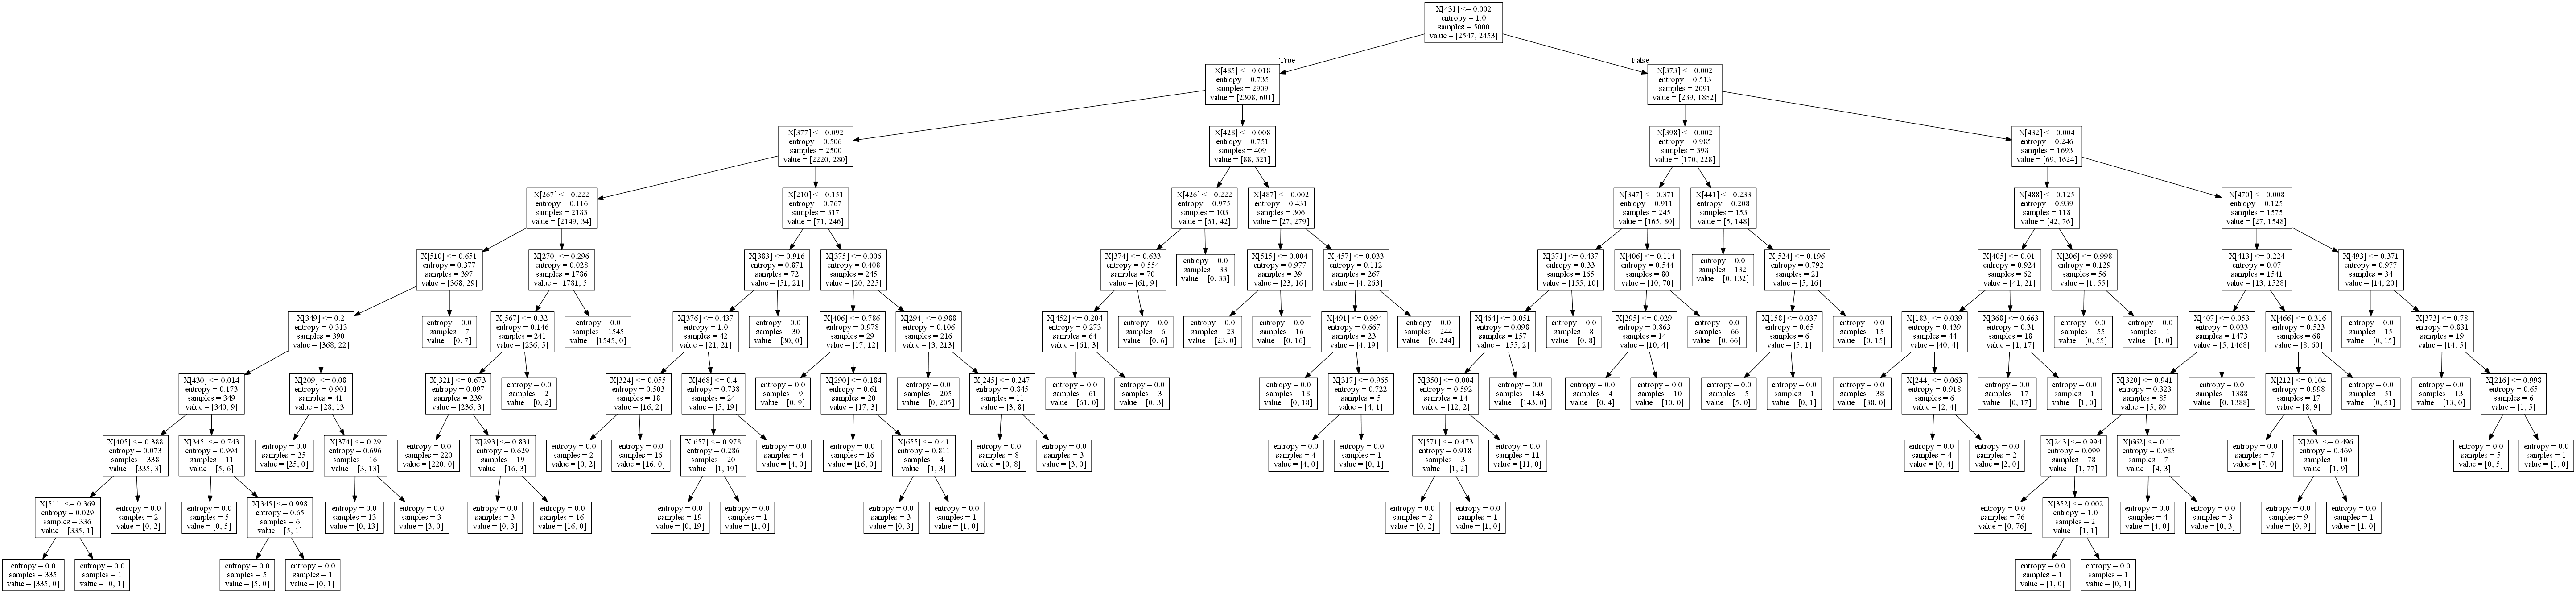

In [22]:
# printing plot
plot_dtree(dtmodel, 'decisionTree.png')
Image("decisionTree.png")

In [23]:
# highest information gain for nines (0, 1388) split
print(round(1 - (85/(85+1388) * 0.323 + 1388/(85+1388) * 0), 3))

# highest information gain for sevens (335, 0) split
print(round(1 - (335/(335+1) * 0 + 1/(335+1) * 0), 3))

0.981
1.0


#### Comments

The decision tree is a greedy algorithm such that when allowed to fully grow, one class dominates in each group as shown here.

The best split for classifying the image data correctly as nines is a 6 partition split with an information gain of 0.981. The best split for sevens which has a 9 partition split with an information gain of 1.0.

The decision tree also has high accuracy, predicting the correct class in the test dataset 96.94% of the time.

### Exercise 2: Naive Bayes (10 marks)

In this task, you will create a multinomial Naive Bayes classifiers and evaluate it. 

You might want to use the following url
http://scikit-learn.org/stable/modules/naive_bayes.html 

In [24]:
# Exercise 2 (10 marks)
# Create multinomial NB
nbclf = MultinomialNB()
nbclf.fit(binary_class_training_data, binary_class_training_labels)
nbpred = nbclf.predict(binary_class_testing_data)
print("Naive Bayes Classification Accuracy: {0:.2f}%"
      .format(metrics.accuracy_score(nbpred, binary_class_testing_labels) * 100 ))

Naive Bayes Classification Accuracy: 91.59%


#### Comments 

The Naive Bayes Classifier has an accuracy of 91.59% which is slighly lower than that achieved by the Decision Tree, possibly as it assumes independence between features. Nevertheless, it is still excellent at classifying handwritten sevens and nines.

### Exercise 3: Logistic Regression (10 marks)

Logistic regression is a simple classifier that converts a regression model into a classification one.
You can read the details at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 


In [25]:
# Exercise 3 (10 marks)
# Create a model with default parameters. Remember to set random state to 1234
lrclf = LogisticRegression(random_state=1234, solver="liblinear")
lrclf.fit(binary_class_training_data, binary_class_training_labels)
lrpred = lrclf.predict(binary_class_testing_data)
print("Logistic Regression Classification Accuracy: {0:.2f}%"
      .format(metrics.accuracy_score(lrpred, binary_class_testing_labels) * 100 ))

Logistic Regression Classification Accuracy: 95.73%


#### Comments

The Logistic Regression Classifier has an accuracy of 95.73%.

### Exercise 4: Random Forests (10 marks)

Random Forests is a very popular ensemble method. See url 
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
for details. Implement a Random Forest (10 marks)

In [26]:
# Exercise 4 (10 marks)
# Create a random forest classifier with Default parameters

# added n_estimator to remove future warning
rfclf = RandomForestClassifier(random_state=1234, n_estimators=10) 
rfclf.fit(binary_class_training_data, binary_class_training_labels)
rfpred = rfclf.predict(binary_class_testing_data)
print("Random Forest Classification Accuracy: {0:.2f}%"
      .format(metrics.accuracy_score(rfpred, binary_class_testing_labels) * 100 ))

Random Forest Classification Accuracy: 97.39%


#### Comments

The Random Forest Classifier has an accuracy of 97.39%.

## Part 2: Exploration of Different Evaluation Metrics for Binary Classification

Let us evaluate different metrics for the binary classification models that we created so far. 
You may want to check the url http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics for additional details.

### Exercise 5: Print the classification results (total: 20 marks)

For each of the models above:

- Task 5a: Print the classification report and confusion matrix (5 marks)
- Task 5b: Print the ROC curve (5 marks)
- Task 5c: Print the AUC curve (5 marks)
- Task 5d: Print the precision/recall curve (5 marks)

In [32]:
# Task t5a (5 marks)
# Print the classification report and confusion matrix for each of the models above

#### Decision Tree Classification Report and Confusion Matrix

              precision    recall  f1-score   support

           7       0.97      0.97      0.97      4746
           9       0.96      0.97      0.97      4505

   micro avg       0.97      0.97      0.97      9251
   macro avg       0.97      0.97      0.97      9251
weighted avg       0.97      0.97      0.97      9251



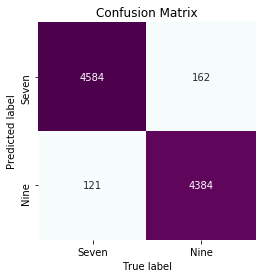

In [27]:
# Decision Tree
print(metrics.classification_report(binary_class_testing_labels, dtpred))
dt_mat = metrics.confusion_matrix(binary_class_testing_labels, dtpred)

# function for plotting confusion matrix with nice labels and colour
def plot_confusion_matrix (matrix, title = "Confusion Matrix"):
    sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap="BuPu",
               xticklabels=("Seven", "Nine"), yticklabels=("Seven", "Nine"))
    plt.title(title)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

plot_confusion_matrix(dt_mat)

#### Naive Bayes Classification Report and Confusion Matrix

              precision    recall  f1-score   support

           7       0.95      0.88      0.91      4746
           9       0.88      0.95      0.92      4505

   micro avg       0.92      0.92      0.92      9251
   macro avg       0.92      0.92      0.92      9251
weighted avg       0.92      0.92      0.92      9251



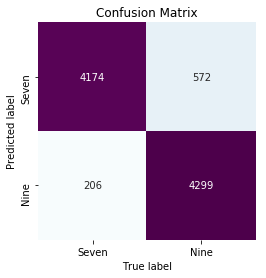

In [28]:
# Naive Bayes
print(metrics.classification_report(binary_class_testing_labels, nbpred))
nb_mat = metrics.confusion_matrix(binary_class_testing_labels, nbpred)
plot_confusion_matrix(nb_mat)

#### Logistic Regression Classification Report and Confusion Matrix

              precision    recall  f1-score   support

           7       0.96      0.96      0.96      4746
           9       0.96      0.95      0.96      4505

   micro avg       0.96      0.96      0.96      9251
   macro avg       0.96      0.96      0.96      9251
weighted avg       0.96      0.96      0.96      9251



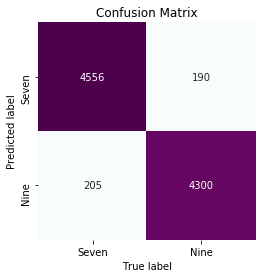

In [29]:
# Logistic Regression
print(metrics.classification_report(binary_class_testing_labels, lrpred))
lr_mat = metrics.confusion_matrix(binary_class_testing_labels, lrpred)
plot_confusion_matrix(lr_mat)

#### Random Forest Classification Report and Confusion Matrix

              precision    recall  f1-score   support

           7       0.97      0.98      0.97      4746
           9       0.98      0.97      0.97      4505

   micro avg       0.97      0.97      0.97      9251
   macro avg       0.97      0.97      0.97      9251
weighted avg       0.97      0.97      0.97      9251



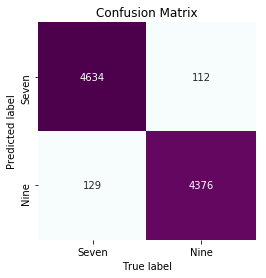

In [30]:
# Random Forest
print(metrics.classification_report(binary_class_testing_labels, rfpred))
rf_mat = metrics.confusion_matrix(binary_class_testing_labels, rfpred)
plot_confusion_matrix(rf_mat)

#### Comments

As shown above, the Decision Tree and Random Forest classifiers had the best performance with a macro-averaged F1 score of 0.97 each. The Logistic Regression classifier performed slightly poorer with a macro-averaged F1 score of 0.96 with slightly more misclassified images of sevens and nines. 

The classifier with the worst performance was the Naive Bayes classifier with a macro-averaged F1 score of 0.92. Recall for sevens and precision for nines was poorer at 0.88 each as more nines were misclassified as sevens. Thus far, the results agree with those found by the classification accuracy score. Also, micro and macro averaged scores are the same as the classes (7 and 9) are balanced.

In [33]:
# Task t5b (5 marks)

In [217]:
# Each of the model above has some probabilistic interpretation
# So sklearn allows you to get the probability values as part of classification
# Using this information, you can print roc_curve
# See http://nbviewer.ipython.org/github/datadave/GADS9-NYC-Spring2014-Lectures/blob/master/lessons/lesson09_decision_trees_random_forests/sklearn_decision_trees.ipynb
# Write code here

# changing the true labels of 7s and 9s to 0 and 1 to match predictions
binary_class_testing_labels_zero = np.copy(binary_class_testing_labels)
binary_class_testing_labels_zero[binary_class_testing_labels_zero == 7] = 0
binary_class_testing_labels_zero[binary_class_testing_labels_zero == 9] = 1

# places classifier predicted labels into a list
dtprob_pred = [p[1] for p in dtclf.predict_proba(binary_class_testing_data)]
nbprob_pred = [p[1] for p in nbclf.predict_proba(binary_class_testing_data)]
lrprob_pred = [p[1] for p in lrclf.predict_proba(binary_class_testing_data)]
rfprob_pred = [p[1] for p in rfclf.predict_proba(binary_class_testing_data)]

# function for plotting roc curves so no text from plt and for looping
def plot_roc_curve(clf, clf_name, predictions):
    # Arguments for plotting the ROC Curve
    fpr_p, tpr_p, thresholds_p = metrics.roc_curve(binary_class_testing_labels_zero, predictions)
    aucscore = metrics.roc_auc_score(binary_class_testing_labels_zero, predictions)
    plt.plot(fpr_p, tpr_p, color = "darkorange", label = "Area under curve = %0.3f" % aucscore)
    plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(clf_name + ' ROC Curve')
    plt.legend(loc="lower right")

In [243]:
print(np.unique(dtprob_pred)[0])
print(np.unique(dtprob_pred)[1])

0.0
1.0


In [218]:
# placing in dictionary for easy access in loop

clf_names = {"Decision Tree" : [dtclf, 1, dtprob_pred],
             "Naive Bayes" : [nbclf, 2, nbprob_pred],
             "Logistic Regression" : [lrclf, 3, lrprob_pred],
             "Random Forest" : [rfclf, 4, lrprob_pred]}

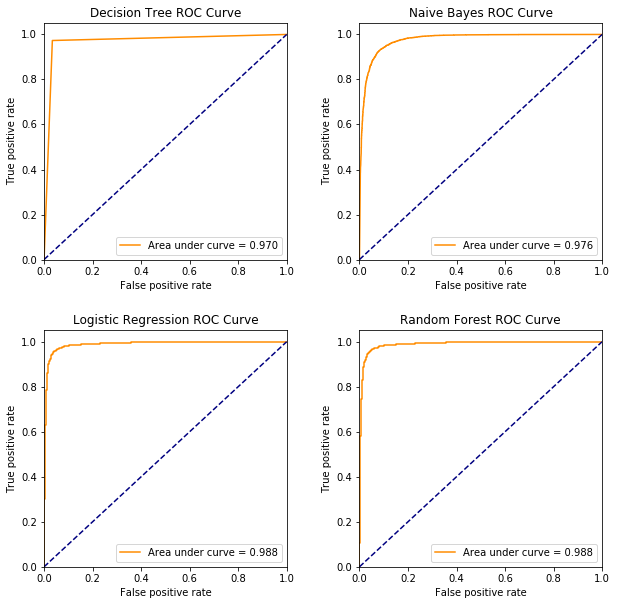

In [219]:
# Plotting ROC Curves

plt.figure(figsize = (10, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
for key, value in clf_names.items():
    plt.subplot(2, 2, value[1])
    plot_roc_curve(value[0], key, value[2])

#### Comments

Consistent with the confusion matrix and classification report scores, the ROC curves show an almost ideal true and false positive rate. The predicted probabilities of each classifier are used here instead of the predicted labels which has shifted the classifier performance such that the worst performing classifier is now the Decision Tree. 

This is possibly due to the cut-off threshold for true and false positive rates favouring the floating point values between 0 and 1 for the other classifiers while the Decision Tree probabilities have remained at 0 and 1.

In [220]:
# task t5c (5 marks)
# Print the AUC value for each of the models above
# Write code here

def auc_score(predictions, clf_name):
    aucscore = metrics.roc_auc_score(binary_class_testing_labels_zero, predictions)
    print(clf_name + " AUC = %0.3f" %aucscore)

for key, value in clf_names.items():
    auc_score(value[2], key)

Decision Tree AUC = 0.970
Naive Bayes AUC = 0.976
Logistic Regression AUC = 0.988
Random Forest AUC = 0.988


In [ ]:
# task t5d (5 marks)
# Print the precision recall curve for each of the models above
# print the curve based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html 
# Write code here


In [235]:
from sklearn.utils.fixes import signature

def plot_precision_recall(clf_name, pred):    
    precision, recall, _ = metrics.precision_recall_curve(binary_class_testing_labels_zero, pred)
    average_precision = metrics.average_precision_score(binary_class_testing_labels_zero, pred)

    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='purple', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.5, color='navy', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(clf_name + ' PRC AP={0:.3f}'
              .format(average_precision))

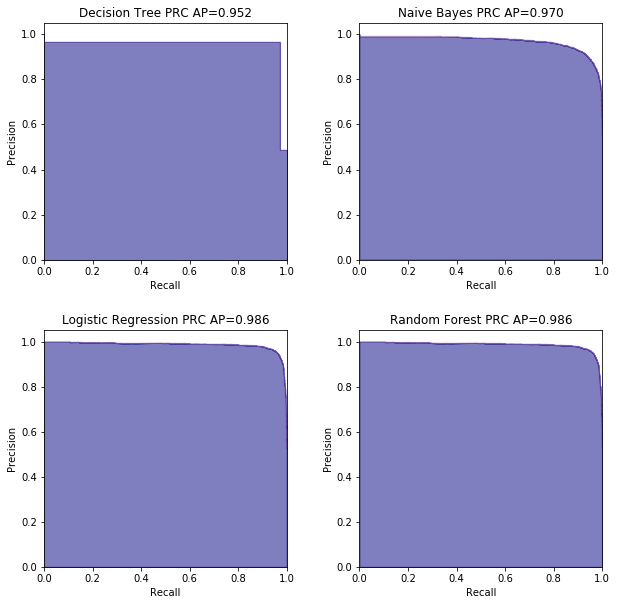

In [236]:
plt.figure(figsize = (10, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
for key, value in clf_names.items():
    plt.subplot(2, 2, value[1])
    plot_precision_recall(key, value[2])

#### Comments

Similarly with the Precision Recall Curves, the Decision Tree classifier has the poorest performance although all classifiers performed exceptionally well with high precision and recall.

## Part 3: Parameter Tuning through Grid Search/Cross Validation and Parallelization

So far in this assignment, you manually tweaked the model till it became better.
For complex models, this is often cumbersome. A common trick people use is called Grid Search where you exhaustively test various parameter combinations
and pick the best set of parameter values. This is a VERY computationally intensive process and hence it will require some parallelization.

In this part, you will learn how to tune Randm Forest for MNIST dataset
and then parallelize it so as to get results faster.
You might want to take a look at the url
http://scikit-learn.org/stable/modules/grid_search.html
for additional details.

One thing you might want to note is that the GridSearchCV uses cross validation for comparing models.

So you have to send the ENTIRE MNIST dataset - i.e. mnist.data and mnist.target. 

The following cell creates two variables all_scaled_data and all_scaled_target that you can pass to GridSearchCV.

In order to get the results in reasonable time, set the **cv** parameter of GridSearchCV to 3.
Also remember to set the **verbose** parameter to 2 to get some details about what happens internally.

In [122]:
all_scaled_data = binary_class_data / 255.0
all_scaled_target = binary_class_labels

### Exercise 6: Tuning parameters for Random Forest using grid search (15 marks)

In [123]:
# Exercise 6 (15 marks)
# Tuning Random Forest for MNIST
tuned_parameters = [{'max_features': ['sqrt', 'log2'], 
                     'n_estimators': [1000, 1500]}] 

# Write code here
rfgrids = GridSearchCV(rfclf, tuned_parameters, cv=3, n_jobs=-1, verbose=2)
rfgrids.fit(all_scaled_data, all_scaled_target)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  2.7min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_features': ['sqrt', 'log2'], 'n_estimators': [1000, 1500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [124]:
# print the details of the best model and its accuracy
print("Best parameters set found on development set:")
print(rfgrids.best_params_)

Best parameters set found on development set:
{'max_features': 'sqrt', 'n_estimators': 1500}


In [127]:
rfclf2 = RandomForestClassifier(max_features = "sqrt", n_estimators = 1500)
rfclf2.fit(binary_class_training_data, binary_class_training_labels)
rfpred2 = rfclf.predict(binary_class_testing_data)
print("Best Random Forest model accuracy: {0:.2f}%:"
      .format(metrics.accuracy_score(rfpred2, binary_class_testing_labels) * 100))

Best Random Forest model accuracy: 97.55%:


#### Comments

Using "sqrt" is equivalent to using the default so changing the number of trees in the forest (i.e. n_estimator) from 10 to 1500 is responsible for the slight improvement in accuracy score from 97.39% to 97.55%. 